# The Working Book for Text Open Classficiation Project

## Project Plan

**Main Project Scopes**

Build  a CNN text classification model as a base, use open max or 1-vs-rest layer as augment final layer

* This implementation will try to mirror the paper
* This is a reference mode to compare our exploration of clustering methods
    
Explore augment method for open classification. Main Method to consider: Clustering method

* Intuition: cluster known class (labelled) data into groups or clusters, when a new unknow data comes in, find the distance function of the cluster for the new data and determine whether it belongs to any existing class or too far away from all of the clusters
* Variations:
    * KNN 
    * Gaussian mixture model
    * Infinite Dirichlet process
* Comparing results and report

**Data Set**

Tentatively we will use newsgroup or news articles as our main dataset for investigation and review. We might consider other dataset if we have time.




## Model Architecture


### Language Model: CNN

**Model Structure and Parameters:**

* Embedding Layer:

    * batch_size: N
    * number of class: M
    * word embedding dimension: d
    * Sentence length: s
    * A sentence matrix has size of $s \times d$
    
    
* CNN Layer

    * Tensor flow cnn: _tf.nn.conv2d_
    * Region size: h e.g. [3, 4, 5] has 3 regions (***Tensor flow define it as height***)
    * Width of the filter: d (***Tensor flow define it as width, usually equal to word embedding dimension***)
    * Number of filters per region: f (***This is equalt to number of feature maps for each region size***)
    * 1 Max-pooling apply to 1 feature map
    
    Use the below image as an example
    
    If we use h = 3 region size [3, 4, 5], width of the filter is d = 5, and 2 filter for each region, we will have 2 feature maps for each regions size and total of 6 feature maps. Max polling will create 6 output vectors. We concatenate to form the feature vector for the output layer. 

![title](cnn.png)

* Output Layer: The DOC paper used 2 fully connected layer convert back to dimension M using $y = W'(ReLU(W \cdot o + b)) + b'$ where:
    * o: feature vector from cnn layer after max-poolling is in $k$
    * W: $r \times k$
    * W': $M \times r$
    * y: $M$

## Open Classification

### Approach to Implement

* 1-vs-Rest Layer of DOC (This is the method of reference paper)

    * M (number of class) sigmoid function, N (batch_size)
    * Objective function for training is $$loss = \sum_{i=1}^M \sum_{i=1}^N y_n log(p) + (1 - y_n)log(1 - p(y))$$ is the summation of all log loss (cross-entropy) on the training data.
    * At prediction, reject if all predicted probability is less than their threshold t_i, otherwise $argmax(Sigmoid(d))$
    * The theshold is determined by using outlier detection. (***We can use a fixed number such as 0.95 to validate our model implementation***)


* Clustering Approach (**NEW**)
    * KNN
    * Gausian Mix Model
    * Infinite Dirichlet process

## First Iteration

### Using simple models to explorer concept of open classification

Open classification is a new concept and we will use some simple model to understand how open classification works and how it is different from the traditional supervised learning setting.

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
# General libraries.
import re
import numpy as np
import sys
import matplotlib.pyplot as plt
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, join
import os
import collections
import random
from pprint import pprint

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from sklearn.metrics import classification_report

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/levi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
PROJECT_PATH = '/home/levi/Documents/MIDS/W266/w266_project'
PROJECT_DATA = os.path.join(PROJECT_PATH, '/Data_Set/')

In [4]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
list(newsgroups_train.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 1. Bag of words model

BOW is a first simple document model to be consider. It is commonly used as baseline language model.

* Each row is one document
* Each column is the 1-hot vector presentation of the document

#### Experiment 5 + 1 open classification with BOW model

In [5]:
categories = ['alt.atheism', 'sci.space', 'comp.graphics', 'talk.politics.guns', 'rec.autos', 'misc.forsale']
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'),
                                     categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'),
                                    categories=categories)
test_data, test_labels = newsgroups_test.data, newsgroups_test.target
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

** Remove 1 class from training data, test data has all 6 classes **

In [6]:
class5_idx = np.where(train_labels == 5)[0]
train_data_open = [train_data[i] for i in range(len(train_data)) if i not in class5_idx]
train_labels_open = np.array([train_labels[i] for i in range(len(train_labels)) if i not in class5_idx])

In [7]:
print 'training open data shape:', len(train_data_open)
print 'training open label shape:', train_labels_open.shape
print 'test data shape', len(test_data)
print 'test label shape:', test_labels.shape
print 'labels names:', newsgroups_train.target_names

training open data shape: 2836
training open label shape: (2836,)
test data shape 2252
test label shape: (2252,)
labels names: ['alt.atheism', 'comp.graphics', 'misc.forsale', 'rec.autos', 'sci.space', 'talk.politics.guns']


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import *
from scipy import *

# Vectorize the data using sparse matrix
# Each column is a doc, each row is BOW vector
vectorizer = CountVectorizer()
train_words_mat = vectorizer.fit_transform(train_data_open)
test_words_mat = vectorizer.transform(test_data)

In [9]:
print "Size of BOW Matrix", train_words_mat.shape
print "Size of test Matrix", test_words_mat.shape
print "Size of vocabulary: ", train_words_mat.shape[1]
print "Number of non-zero elements:", train_words_mat.nnz
print "Training_label Size: ", train_labels.shape

Size of BOW Matrix (2836, 30158)
Size of test Matrix (2252, 30158)
Size of vocabulary:  30158
Number of non-zero elements: 237343
Training_label Size:  (3382,)


#### Run logistical regression unit test

In [13]:
from sklearn.linear_model import LogisticRegression

logitReg = LogisticRegression(C = 1.0)
logitReg.fit(train_words_mat, train_labels_open)
pred = logitReg.predict(test_words_mat)
pred_prob = logitReg.predict_proba(test_words_mat)
coef_logit = logitReg.coef_
sum_sq_weight = np.sum(coef_logit**2, axis = 1)

f1_score_logit = metrics.f1_score(test_labels, pred, average="macro")
print "C =%2d f1_score = %f " %(i, metrics.f1_score(test_labels, pred, average="macro")),
print "Sum of square weight of each class: ", sum_sq_weight

C =3381 f1_score = 0.607024  Sum of square weight of each class:  [ 151.33057218  173.61900423  146.29028757  192.79846499  186.30686131]


/home/levi/anaconda3/envs/p2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
open_class_idx = np.where(test_labels == 5)[0]
type(open_class_idx)
[pred[i] for i in open_class_idx[:10]]

[0, 4, 4, 0, 3, 3, 4, 0, 0, 0]

### 2. Word2Vec model

In [15]:
# Standard python helper libraries.
import os, sys, re, json, time
import itertools, collections
from IPython.display import display

# NumPy and SciPy for matrix ops
import numpy as np
import scipy.sparse

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# NLTK for NLP utils
import nltk

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz
import part2_helpers

**Build a corpus from plain text of 20 newsgroup data**

* More prepocessing can be added

In [20]:
from nltk.corpus import PlaintextCorpusReader

# RegEx or list of file names
data_20newsgroup = PROJECT_DATA + 'total_20news.txt'

corpus = PlaintextCorpusReader(PROJECT_PATH+PROJECT_DATA+'/newsgroup_raw/', '.*\.txt')

for infile in sorted(corpus.fileids()):
    print infile # The fileids of each file.

20news-bydate-test.txt
20news-bydate-train.txt


**Create an embedding layer with SVD of dimension = 100**

In [21]:
def embeddings_from_text(corpus_in, K=1, d=100):

    corpus = corpus_in
    vocab = vocabulary.Vocabulary(utils.canonicalize_word(w) for w in utils.flatten(corpus.sents()))
    print "Vocabulary: %d words" % vocab.size

    tokens = part2_helpers.sents_to_tokens(corpus.sents(), vocab)
    print "%g tokens" % len(tokens)
    token_ids = vocab.words_to_ids(tokens)
    
    ##
    # Compute co-occurrence matrix and word vectors
    t0 = time.time()
    C = part2_helpers.cooccurrence_matrix(token_ids, vocab.size, K=K)
    print "Computed Co-occurrence matrix in %s" % utils.pretty_timedelta(since=t0); t0 = time.time()
    C_ppmi = part2_helpers.PPMI(C)
    print "Computed PPMI in %s" % utils.pretty_timedelta(since=t0); t0 = time.time()
    Wv, _ = part2_helpers.SVD(C_ppmi, d=d)
    print "Computed SVD in %s" % utils.pretty_timedelta(since=t0)
    
    return Wv, vocab

In [22]:
Wv_test, vocab_test = embeddings_from_text(corpus, K=1, d=100)

Vocabulary: 184041 words
8.69058e+06 tokens
Counting pairs (i, i ± 1) ...
Co-occurrence matrix: 184041 words x 184041 words
  2.7e+06 nonzero elements
Computed Co-occurrence matrix in 0:00:03
Computed PPMI in 0:00:00
Computed SVD in 0:00:09


In [23]:
print Wv_test.shape

(184041, 100)


### 3. TF-IDF model

In [24]:
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
import re, string, timeit


def preprocessing(text,stem=False, stop=False, sent=False):
    # Remove punctuations
    #exclude = set(string.punctuation)
    #text = ''.join(ch for ch in text if ch not in exclude)
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub('', text)
    tokens = word_tokenize(text) 
    if stop:
        stop = stopwords.words('english')
        tokens =[word for word in tokens if word not in stop]
        tokens = [word.lower() for word in tokens]
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
    if sent:
        tokens = ' '.join(tokens)
    return tokens

TF-IDF Model

In [26]:
vectorizer = TfidfVectorizer(tokenizer=preprocessing,
                             stop_words=stopwords.words('english'))
le = LabelEncoder()

# Training 
vectors_train = vectorizer.fit_transform(newsgroups_train.data)
labels_train = le.fit_transform(newsgroups_train.target)

# Just for debug quickly reassign labels
X = vectors_train
y = labels_train


#clf = MultinomialNB(alpha=.01)
clf = svm.SVC(kernel='linear', C = 1.0)

# Evaluate using cross validation
#cross_val = KFold(len(newsgroups_train.target),n_folds=5,shuffle=True)

clf.fit(vectors_train, newsgroups_train.target)
vectors_test = vectorizer.transform(newsgroups_test.data)
pred = clf.predict(vectors_test)

#print metrics.f1_score(newsgroups_test.target, pred)
print classification_report(le.inverse_transform(newsgroups_test.target),le.inverse_transform(pred))

             precision    recall  f1-score   support

          0       0.78      0.71      0.74       319
          1       0.86      0.84      0.85       389
          2       0.92      0.87      0.89       390
          3       0.72      0.89      0.80       396
          4       0.78      0.79      0.79       394
          5       0.87      0.76      0.81       364

avg / total       0.82      0.82      0.82      2252



### 4. Doc2Vec model

In [27]:
#Preprocessing for Doc2Vec 
def clean_news(articles):  
    clean = [] 
    for article in articles:
        clean.append(preprocessing(article,stop=True,sent=False, stem=False))
    return clean
        

newsgroups_train.data = clean_news(newsgroups_train.data)
newsgroups_test.data = clean_news(newsgroups_test.data)

In [28]:
from collections import namedtuple
import nltk
from gensim.models.doc2vec import  LabeledSentence
import sys


all_newsgroup_documents = []

#Used to convert newsgroup corpus into Doc2Vec formats
def convert_newsgroup(docs,split):
    #global doc_count
    tagged_documents = []
    
    for i,v in enumerate(docs):
        label = '%s_%s'%(split,i)
        tagged_documents.append(LabeledSentence(v, [label]))
    
    return tagged_documents
     
test_docs = convert_newsgroup(newsgroups_test.data,'test')
train_docs = convert_newsgroup(newsgroups_train.data,'train')

all_newsgroup_documents.extend(train_docs)
all_newsgroup_documents.extend(test_docs)

doc_list = all_newsgroup_documents[:]  # for reshuffling per pass

print('%d docs: %d train, %d test' % (len(doc_list), len(train_docs), len(test_docs)))
print(len(newsgroups_train.target))

5634 docs: 3382 train, 2252 test
3382


In [29]:
# Set up Doc2Vec

from gensim.models import *
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

dbow_model = Doc2Vec(dm=0, dm_concat=1,sample=1e-5, size=300, window=5, negative=5, hs=0, min_count=2, workers=10)
dm_model =  Doc2Vec(dm=1, dm_mean=1, sample=1e-5, size=300, window=10, negative=5, hs=0, min_count=2, workers=10)
dbow_model.build_vocab(all_newsgroup_documents)
dm_model.build_vocab(all_newsgroup_documents)


dbow_dmm_model = ConcatenatedDoc2Vec([dbow_model, dm_model])

### Training

In [30]:
from collections import defaultdict
best_error = defaultdict(lambda :1.0)

#Get Vectors From Word2Vec
def extract_vectors(model,docs):    
    vectors_list = []
    for doc_no in range(len(docs)):
        doc_label = docs[doc_no].tags[0]
        doc_vector = model.docvecs[doc_label]
        vectors_list.append(doc_vector)
        
    return vectors_list

# TODO inferred vectors

def get_infer_vectors(model,docs):   
    vecs = []
    for doc in docs:
        vecs.append(model.infer_vector(doc.words))
    return vecs

In [39]:
from random import shuffle
alpha, min_alpha, passes = (0.025, 0.001, 100)
alpha_delta = (alpha - min_alpha) / passes
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

## DOUBLE CHECK ON INPUTS INTO MODEL

for epoch in range(passes):
    shuffle(doc_list)
    print alpha   
    dbow_model.alpha, dbow_model.min_alpha = alpha, alpha
    dbow_model.train(doc_list,total_examples=dbow_model.corpus_count,epochs=dbow_model.iter)
    
    dm_model.alpha, dm_model.min_alpha = alpha, alpha
    dm_model.train(doc_list,total_examples=dm_model.corpus_count,epochs=dm_model.iter)
    
    dbow_dmm_model.alpha, dbow_dmm_model.min_alpha = alpha, alpha
    dbow_dmm_model.train(doc_list,total_examples=dbow_model.corpus_count,epochs=dbow_model.iter)
    alpha -= alpha_delta

0.025
0.02476
0.02452
0.02428
0.02404
0.0238
0.02356
0.02332
0.02308
0.02284
0.0226
0.02236
0.02212
0.02188
0.02164
0.0214
0.02116
0.02092
0.02068
0.02044
0.0202
0.01996
0.01972
0.01948
0.01924
0.019
0.01876
0.01852
0.01828
0.01804
0.0178
0.01756
0.01732
0.01708
0.01684
0.0166
0.01636
0.01612
0.01588
0.01564
0.0154
0.01516
0.01492
0.01468
0.01444
0.0142
0.01396
0.01372
0.01348
0.01324
0.013
0.01276
0.01252
0.01228
0.01204
0.0118
0.01156
0.01132
0.01108
0.01084
0.0106
0.01036
0.01012
0.00988
0.00964
0.0094
0.00916
0.00892
0.00868
0.00844
0.0082
0.00796
0.00772
0.00748
0.00724
0.007
0.00676
0.00652
0.00628
0.00604
0.0058
0.00556
0.00532
0.00508
0.00484
0.0046
0.00436
0.00412
0.00388
0.00364
0.0034
0.00316
0.00292
0.00268
0.00244
0.0022
0.00196
0.00172
0.00148
0.00124


### Evaluation

In [41]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

train_vectors = extract_vectors(dbow_dmm_model,train_docs)
test_vectors = extract_vectors(dbow_dmm_model,test_docs)
class_7_idx = np.where(newsgroups_train.target == 7)[0]
train_new_vectors = [train_vectors[i] for i in range(len(train_vectors)) if i not in class_7_idx]
train_new_labels = [newsgroups_train.target[i] for i in range(len(newsgroups_train.target)) if i not in class_7_idx]

clf = OneVsRestClassifier(SVC(kernel='sigmoid', probability=True))
#clf = LinearSVC(C=0.0025)
#clf = MultinomialNB(alpha=.01)
#clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
#clf =RandomForestClassifier(max_depth=5)
#clf = GradientBoostingClassifier(loss = 'deviance', learning_rate = 0.1, verbose=1)
clf.fit(train_new_vectors, train_new_labels)

predDoc = clf.predict_proba(test_vectors)
        
#print classification_report(le.inverse_transform(newsgroups_test.target),le.inverse_transform(predDoc))

In [42]:
predDoc[2]

array([  8.45058713e-05,   2.37857112e-03,   7.24802657e-03,
         6.29593360e-01,   3.53614191e-01,   7.08134567e-03])

In [44]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


IndexError: index 6 is out of bounds for axis 1 with size 6

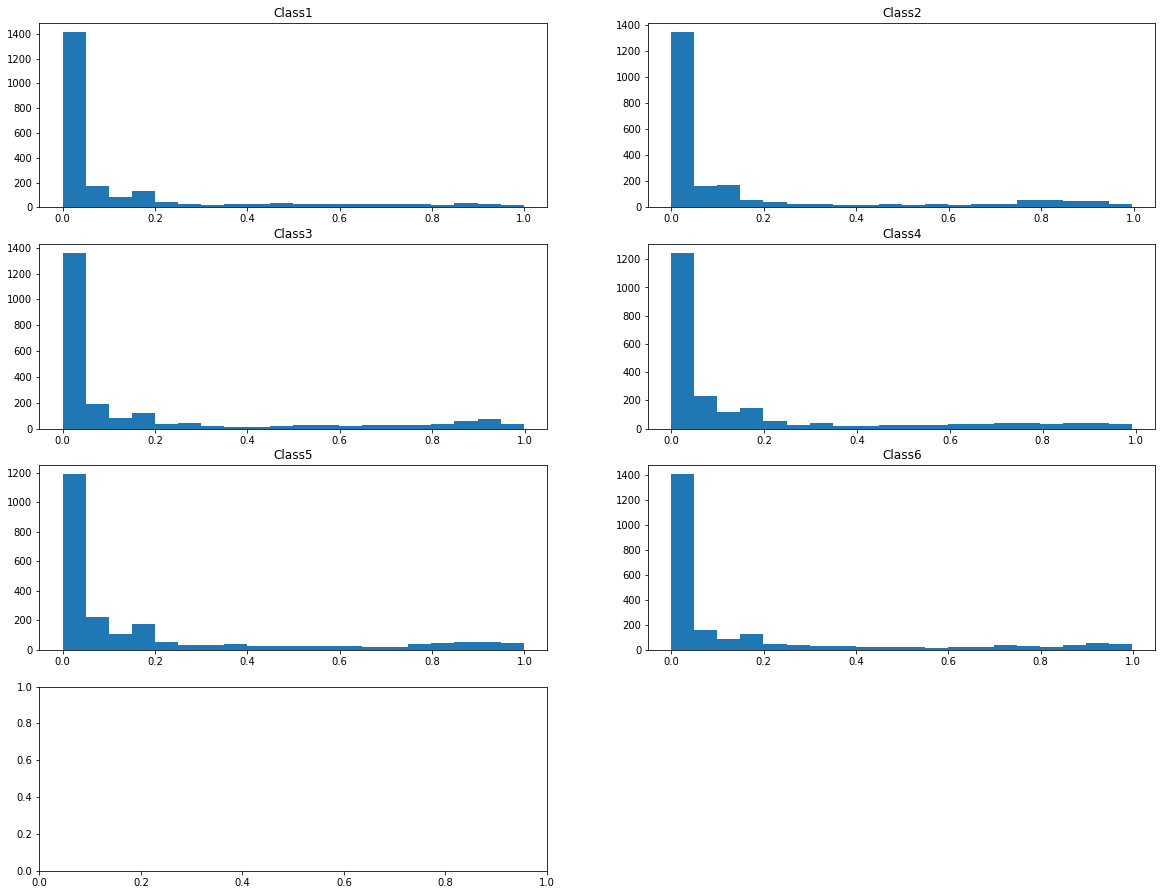

In [45]:
fig = plt.figure(figsize=(20, 40)) 
#f,a = plt.subplots(7,3 )
#a = a.ravel()

for idx in range(19):
    ax = fig.add_subplot(10, 2, idx+1)
    ax.hist(predDoc[:,idx], bins=20)
    txt = "Class"+str(idx+1)
    ax.set_title(label=txt)

    

## **Create Word Embedding use BOV appoach**

## 1-vs-Rest Sigmoid Classification

In [ ]:
import math
from sklearn.metrics import log_loss

def sigmoid(x):
      return 1 / (1 + math.exp(-x))
    
def loss_function(train_data, train_label)